# GEE Bayer example notebook 3
## Correlating spectral indices from Sentinel-2 to precipitation

In [1]:
# pre-install and import all the libraries in one go
import numpy as np
import ee   
import numpy as np
import os
import time
import pandas as pd
import geemap
import geemap.colormaps as cm

In [2]:
try:
  ee.Initialize()
except:
  ee.Authenticate()
  ee.Initialize()

In [ ]:
ee.data.setDefaultWorkloadTag('ee-gee-test-notebook3-evandelancey')

## Sentinel-2 functions

In [24]:
#adding indicies
def addInd(i):
  ndvi = i.normalizedDifference(['B8', 'B4']).rename('NDVI')
  gndvi = i.normalizedDifference(['B8', 'B3']).rename('GNDVI')
  ndmi = i.normalizedDifference(['B11', 'B8']).rename('NDMI')
  ndti = i.normalizedDifference(['B11', 'B12']).rename('NDTI')
  ndpi = i.expression(
    '(N - (0.74 * R + (1.0 - 0.74) * S1))/(N + (0.74 * R + (1.0 - 0.74) * S1))', {
      'N': i.select(['B8']),
      'R': i.select(['B4']),
      'S1': i.select(['B11']),
    }).rename(['NDPI'])
  savi = i.expression(
    '(1.0 + 0.5) * (N - R) / (N + R + 0.5)', {
      'N': i.select(['B8']),
      'R': i.select(['B4']),
    }).rename(['SAVI'])
  s2rep = i.expression(
    '705.0 + 35.0 * ((((RE3 + R) / 2.0) - RE1) / (RE2 - RE1))', {
      'R': i.select(['B4']),
      'RE1': i.select(['B5']),
      'RE2': i.select(['B6']),
      'RE3': i.select(['B7']),
    }).rename(['S2REP'])
  return i.addBands(ndvi).addBands(gndvi).addBands(ndmi).addBands(ndti).addBands(ndpi).addBands(savi).addBands(s2rep)

#functions for cloud free Sentinel-2 image collection
def s2Util (s2_img):
    return s2_img.updateMask(s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()))
def s2Util2 (img):
    return ee.Image(img).updateMask(ee.Image(img.get('cloud_mask')).select('probability').lt(20));

def s2_cloudless (maxCloud, S2Collection):
      s2Clouds = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
      s2Sr = S2Collection.map(s2Util)
      # Join S2 SR with cloud probability dataset to add cloud mask.
      return ee.ImageCollection(ee.Join.saveFirst('cloud_mask').apply(**{
        'primary': s2Sr,
        'secondary': s2Clouds,
        'condition': ee.Filter.equals(**{'leftField': 'system:index', 'rightField': 'system:index'})
      }).map(s2Util2))

#list of unique dates
def ymdList(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"));
        newlist = ee.List(newlist);
        return ee.List(newlist.add(date).sort())
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).reduce(ee.Reducer.frequencyHistogram()).getInfo().keys())

## Get Sentinel-2 for the whole year of 2022

In [94]:
#Sentinel-2 data
geom = ee.Geometry.BBox(-121.775764, 37.416014, -121.769112, 37.420122)
geomFC = ee.FeatureCollection([ee.Feature(geom)])
s2_ic = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate('2022-01-01', '2023-01-01').filterBounds(geom)
s2_ic = s2_ic.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
s2_ic = s2_cloudless(20, s2_ic)
s2_ic = s2_ic.map(addInd)
print('Sentinel-2 image collection size',s2_ic.size().getInfo())
s2_im = s2_ic.median()

s2Map = geemap.Map()
s2Map.centerObject(geom)
s2Map.addLayer(s2_im, {'min':0, 'max':3000, 'bands': ['B4', 'B3', 'B2']}, '2022 Sentinel-2')
s2Map.addLayer(geom, {"color": '#00000000'}, 'geometry')
s2Map


Sentinel-2 image collection size 85


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Get CHIRPS precip data for all of 2022

In [95]:
#CHIRPS daily precip
precip_ic = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate('2022-01-01', '2023-01-01')
precip_im = precip_ic.sum()

precipMap = geemap.Map()
precipMap.centerObject(geom, 9)
precipMap.addLayer(precip_im, {'min':0, 'max':1000, 'palette': ['red', 'yellow', 'blue']}, 'sum precip')
precipMap.addLayer(geom, {"color": '#00000000'}, 'geometry')
precipMap

Map(center=[37.418067998714086, -121.77243799997117], controls=(WidgetControl(options=['position', 'transparen…

## Every Sentinel-2 date get the mean index and cumulative rain for the past 2 weeks

In [96]:
#correlate VIs and precip by reducing over region every S2 date
dateList = ymdList(s2_ic)


dateList = [item[:4] + '-' + item[4:6] + "-" + item[6:8] for item in dateList]
print('list of days with Sentinel-2 imagery', dateList)
dateList = ee.List(dateList)


def tsValueExtract (date):
    startD = ee.Date(date)
    endD = startD.advance(1, 'day')
    startD_precip = endD.advance(-14, 'day')
    
    s2Day = s2_ic.filterDate(startD, endD).select(['NDVI', 'NDMI', 'SAVI']).median()
    precipWeek = precip_ic.filterDate(startD_precip, endD).sum()
    
    dataStack = s2Day.addBands(precipWeek)
    
    extract = dataStack.reduceRegions(**{'collection': geomFC, 'reducer': ee.Reducer.mean(), 'scale': 30})
    return ee.Feature(extract)

precip_VI_table = ee.FeatureCollection(dateList.map(tsValueExtract)).flatten().filter(ee.Filter.neq('NDVI', None))
#print(precip_VI_table.getInfo())

index = 'NDMI'
vi = precip_VI_table.aggregate_array(index).getInfo()
precip = precip_VI_table.aggregate_array('precipitation').getInfo()
    
    

list of days with Sentinel-2 imagery ['2022-01-09', '2022-01-19', '2022-01-24', '2022-02-08', '2022-02-13', '2022-02-18', '2022-02-23', '2022-02-28', '2022-03-10', '2022-03-20', '2022-03-25', '2022-04-04', '2022-04-09', '2022-04-24', '2022-04-29', '2022-05-04', '2022-05-09', '2022-05-14', '2022-05-19', '2022-05-24', '2022-05-29', '2022-06-13', '2022-06-18', '2022-06-23', '2022-06-28', '2022-07-08', '2022-07-13', '2022-07-18', '2022-07-23', '2022-08-02', '2022-08-07', '2022-08-12', '2022-08-22', '2022-08-27', '2022-09-01', '2022-09-06', '2022-09-16', '2022-09-26', '2022-10-01', '2022-10-06', '2022-10-11', '2022-10-16', '2022-10-21', '2022-10-26', '2022-11-10', '2022-11-15', '2022-11-20', '2022-11-25', '2022-11-30', '2022-12-05', '2022-12-15', '2022-12-20']


## plot this

<Axes: xlabel='precip', ylabel='NDMI'>

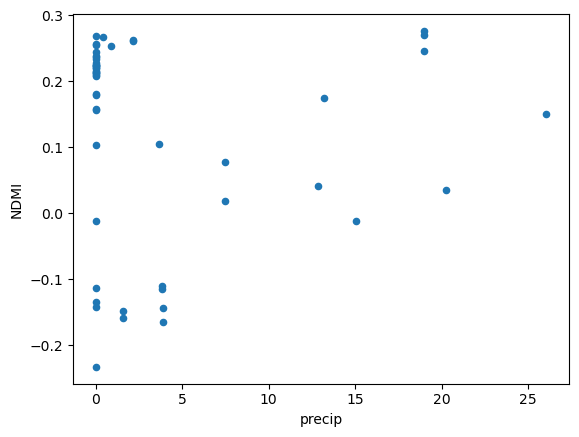

In [97]:
d = {index: vi, 'precip': precip}
df = pd.DataFrame(data=d)
df.plot.scatter(x="precip", y=index)